# Assignment 9: Harris Corner and Keypoint Matching
Tổng quan: Ở bài tập này, chúng ta sẽ thực hành lập trình một số hàm như phát hiện góc bằng Harris corner, mô tả và nối keypoint của các ảnh: descibe keypoints, match descriptors,... 

Yêu cầu thư viện: OpenCV 3.3, matplotlib, skimage 

In [1]:
from IPython.display import Image
from skimage.feature import corner_peaks

import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

## I. Harris Corner Detector
Harris Corner là một phương pháp phát hiện các điểm (có tính chất) góc trong ảnh, thường được sử dụng khi tính toán các đặc trưng ảnh cho các bài toán thị giác máy tính.


Thư viện OpenCV cung cấp hàm cv2.cornerHarris() để phát hiện các điểm góc trong ảnh. Tham số như sau:
- img - Input image, it should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html


Hãy hoàn thành hàm detect_corner(), với các tham số sau:

Input:
- image_path: Đường dẫn file ảnh
- blockSize, ksize, k: tham số của hàm cv2.cornerHarris()
- threshold: ngưỡng để coi 1 điểm là góc

Output:
- Đường dẫn tới file ảnh đầu ra

In [2]:
from skimage import filters
from skimage.util.shape import view_as_blocks
from scipy.spatial.distance import cdist
from scipy.ndimage.filters import convolve


def harris_corners(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.ndimage.filters.convolve, 
        which is already imported above
        
    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response = np.zeros((H, W))

    dx = filters.sobel_v(img)
    dy = filters.sobel_h(img)

    ### YOUR CODE HERE
    A = convolve(dx ** 2, window)
    B = convolve(dx * dy, window)
    C = convolve(dy ** 2, window)
    for i in range(H):
        for j in range(W):
            M = np.array([[A[i, j], B[i, j]], [B[i, j], C[i, j]]])
            response[i, j] = np.linalg.det(M) - k * np.trace(M) ** 2
    ### END YOUR CODE

    return response

In [4]:
def detect_corner(image_path, blockSize=2, ksize=3, k=0.04, threshold=0.01):
    """
    image_path: link to image
    blockSize: the size of neighbourhood considered for corner detection
    ksize: parameter of Sobel derivative
    k: Harris detector free parameter in the equation.
    """
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,blockSize,ksize,k)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>threshold*dst.max()]=[0,0,255]
    
    cv2.imwrite('example.png',img)
    return 'example.png'

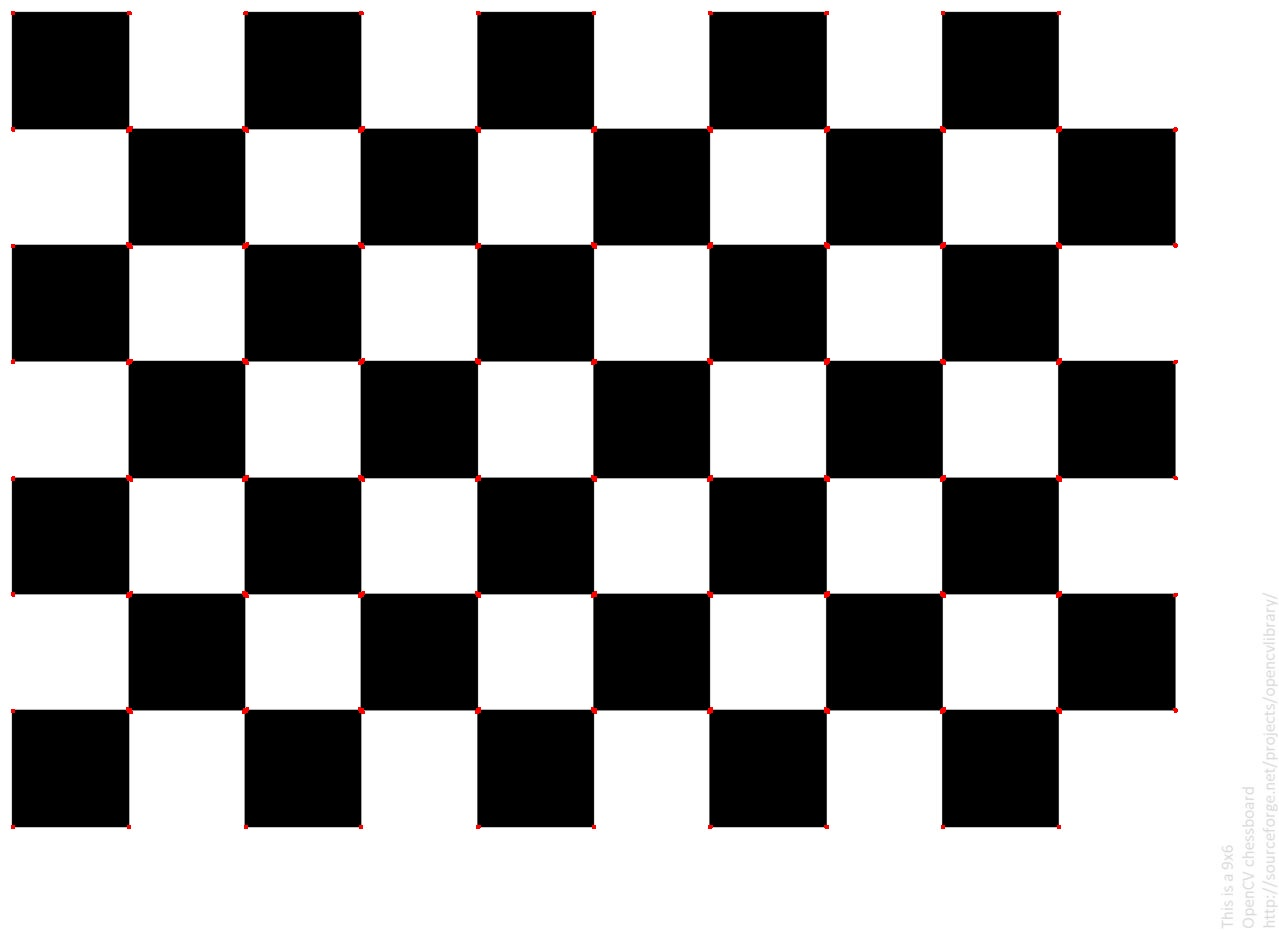

In [4]:
out_path = detect_corner('chessboard.jpg')
# out_path = detect_corner('sudoku.png')
Image(out_path)

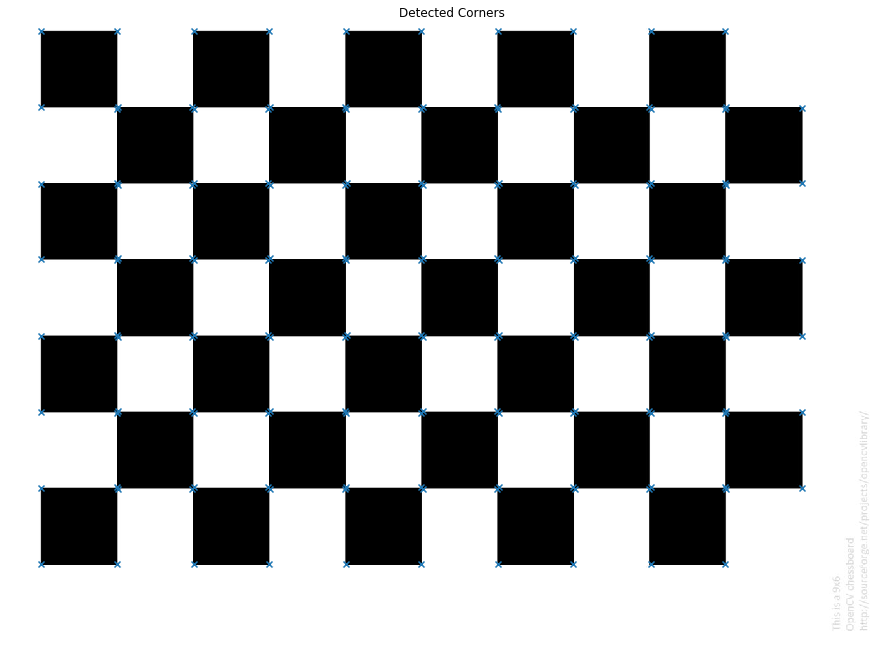

In [5]:
# Perform non-maximum suppression in response map
# and output corner coordiantes
image_path = 'chessboard.jpg'
img = cv2.imread(image_path, 0)
blockSize=2; ksize=3; k=0.04
response = cv2.cornerHarris(img,blockSize,ksize,k)
# response = harris_corners(img)
corners = corner_peaks(response, threshold_rel=0.01)

# Display detected corners
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plt.imshow(img, cmap='gray')
plt.scatter(corners[:,1], corners[:,0], marker='x')
plt.axis('off')
plt.title('Detected Corners')
plt.show()

Hãy thử tùy chỉnh tham số của hàm detect_corner() với ảnh 'house.jpg' sau sao cho ảnh đầu ra phát hiện được nhiều góc chính xác nhất.

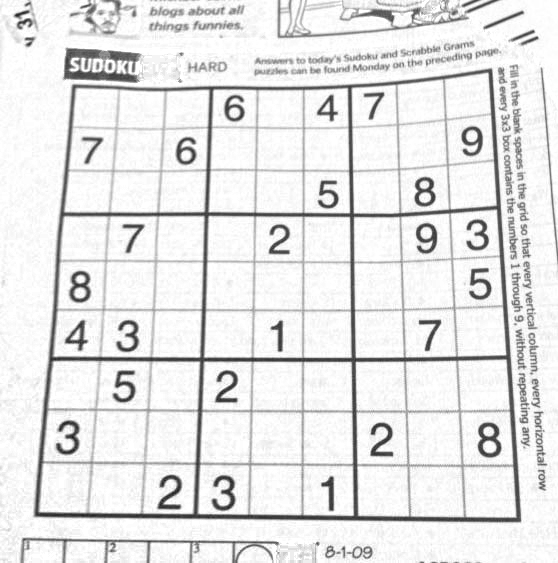

In [7]:
Image('sudoku.png')

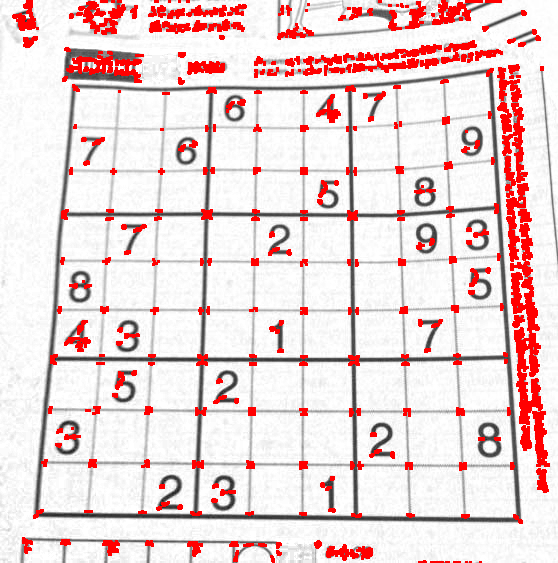

In [8]:
out_path = detect_corner('sudoku.png', blockSize=2, ksize=5, k=0.04, threshold=0.005)
Image(out_path)

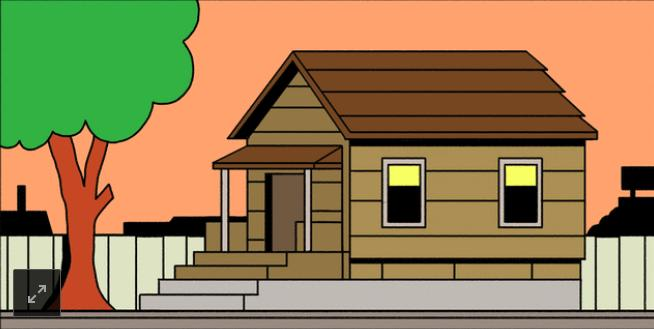

In [9]:
Image('house.jpg')

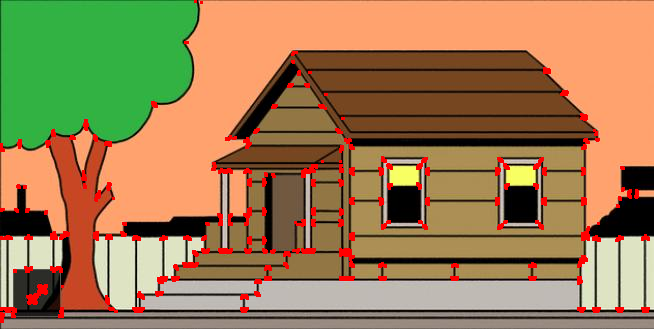

In [5]:
out_path = detect_corner('house.jpg', blockSize=2, ksize=5, k=0.04, threshold=0.005)
Image(out_path)

In [22]:
def shi_tomasi_detect_corner(img_path, maxCornerNB, qualityLevel, minDistance=0.6):
    img = cv2.imread(img_path)
    
    # convert to gray image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # shi tomasi detect corners
    corners = cv2.goodFeaturesToTrack(gray, maxCornerNB, qualityLevel, minDistance)
    corners = np.int0(corners)

    for i in corners:
        # take (x, y) of corners
        x, y = i.ravel()
        
        # draw circle
        cv2.circle(img, (x,y), 3, (0, 0, 255), -1)

    cv2.imwrite('example_shitomasi.png', img)
    return 'example_shitomasi.png'

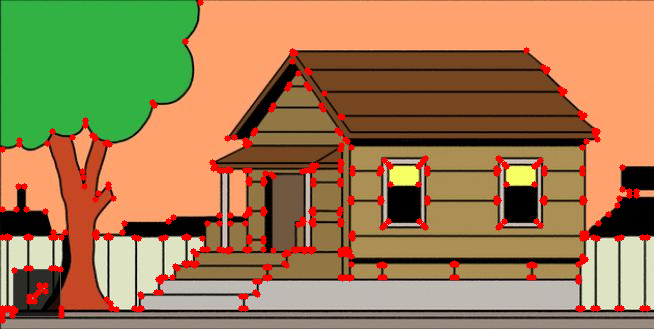

In [28]:
img_path = shi_tomasi_detect_corner('house.jpg', 600, 0.05)
Image(img_path)

## II. Describing and Matching Keypoints

Ở hàm **`simple_descriptor`**, mỗi keypoint được mô tả bằng cách normalize mức xám trong một vùng xác định quanh keypoint đó.

In [11]:
def simple_descriptor(patch):
    """
    Describe the patch by normalizing the image values into a standard 
    normal distribution (having mean of 0 and standard deviation of 1) 
    and then flattening into a 1D array. 
    
    The normalization will make the descriptor more robust to change 
    in lighting condition.
    
    Hint:
        If a denominator is zero, divide by 1 instead.
    
    Args:
        patch: grayscale image patch of shape (h, w)
    
    Returns:
        feature: 1D array of shape (h * w)
    """
    feature = []
    ### YOUR CODE HERE
    std = np.std(patch)
    mean = np.mean(patch)
    if std > 0.0:
        feature = (patch - mean) / std
    else:
        feature = patch - mean
    feature = feature.reshape(-1)
    ### END YOUR CODE
    return feature

In [12]:
def describe_keypoints(image, keypoints, desc_func, patch_size=16):
    """
    Args:
        image: grayscale image of shape (H, W)
        keypoints: 2D array containing a keypoint (y, x) in each row
        desc_func: function that takes in an image patch and outputs
            a 1D feature vector describing the patch
        patch_size: size of a square patch at each keypoint
                
    Returns:
        desc: array of features describing the keypoints
    """

    image.astype(np.float32)
    desc = []

    for i, kp in enumerate(keypoints):
        y, x = kp
        patch = image[y-(patch_size//2):y+((patch_size+1)//2),
                      x-(patch_size//2):x+((patch_size+1)//2)]
        desc.append(desc_func(patch))
    return np.array(desc)

Hàm **`match_descriptors`** giúp xác định các cặp điểm "match" giữa hai tập desciptors. Đầu tiên, tính khoảng cách Euclid giữa mọi cặp desciptor của ảnh 1 và ảnh 2. Sau đó, tìm kiếm các cặp "match" bằng cách xác định: nếu khoảng cách tới điểm gần nhất nhỏ hơn đáng kể so với khoảng cách tới điểm gần thứ hai, ta coi cặp điểm với khoảng cách gần nhất đó là "match".

In [13]:
from scipy.spatial.distance import cdist

def match_descriptors(desc1, desc2, threshold=0.5):
    """
    Match the feature descriptors by finding distances between them. A match is formed 
    when the distance to the closest vector is much smaller than the distance to the 
    second-closest, that is, the ratio of the distances should be smaller
    than the threshold. Return the matches as pairs of vector indices.
    
    Args:
        desc1: an array of shape (M, P) holding descriptors of size P about M keypoints
        desc2: an array of shape (N, P) holding descriptors of size P about N keypoints
        
    Returns:
        matches: an array of shape (Q, 2) where each row holds the indices of one pair 
        of matching descriptors
    """
    matches = []
    
    N = desc1.shape[0]
    dists = cdist(desc1, desc2)

    ### YOUR CODE HERE
    for i in range(N):
        dist = dists[i, :]
        if np.min(dist) / (np.partition(dist, 2)[1]) <= threshold:
            matches.append([i, np.argmin(dist)])
    matches = np.array(matches).reshape(-1, 2)
    ### END YOUR CODE
    
    return matches

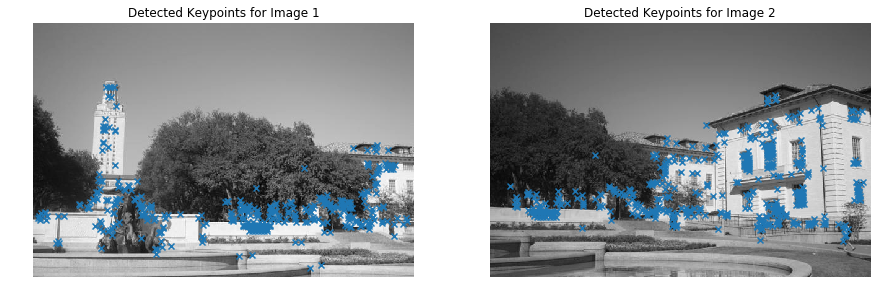

In [14]:
img1 = cv2.imread('uttower1.jpg', 0)
img2 = cv2.imread('uttower2.jpg', 0)

# Detect keypoints in two images
keypoints1 = corner_peaks(cv2.cornerHarris(img1, blockSize=2, ksize=3, k=0.04), 
                          threshold_rel=0.05, exclude_border=8)
keypoints2 = corner_peaks(cv2.cornerHarris(img2, blockSize=2, ksize=3, k=0.04), 
                          threshold_rel=0.05, exclude_border=8)

# keypoints1 = corner_peaks(harris_corners(img1, window_size=3), threshold_rel=0.1, exclude_border=8)
# keypoints2 = corner_peaks(harris_corners(img2, window_size=3), threshold_rel=0.1, exclude_border=8)

# Display detected keypoints
plt.subplots(1, 2, figsize=(15,12))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.scatter(keypoints1[:,1], keypoints1[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 1')

plt.subplot(1,2,2)
plt.imshow(img2, cmap='gray')
plt.scatter(keypoints2[:,1], keypoints2[:,0], marker='x')
plt.axis('off')
plt.title('Detected Keypoints for Image 2')
plt.show()

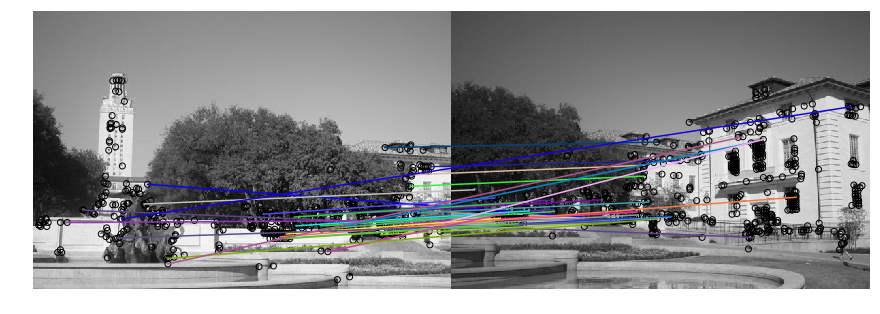

In [15]:
from utils import plot_matches

patch_size = 5

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)
desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=simple_descriptor,
                           patch_size=patch_size)

# Match descriptors in image1 to those in image2
matches = match_descriptors(desc1, desc2, 0.7)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()

# BÀI TẬP VỀ NHÀ

1. Thực hành phát hiện góc trên các ảnh trong thư mục corner.
2. Chụp một số ảnh thực tế. Áp dụng phương pháp Harris corner với cùng bộ tham số trên ảnh với các tỉ lệ scale khác nhau (ví dụ phóng to 2 lần, thu nhỏ 2 lần). So sánh kết quả.
3. Áp dụng các hàm describe và match keypoint đối với các ảnh 'yosemite*.jpg'

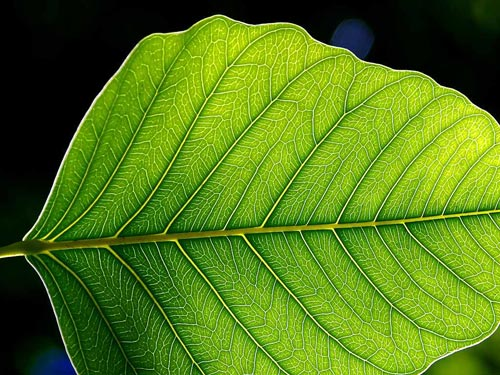

In [16]:
Image('corner/leaf.jpg')

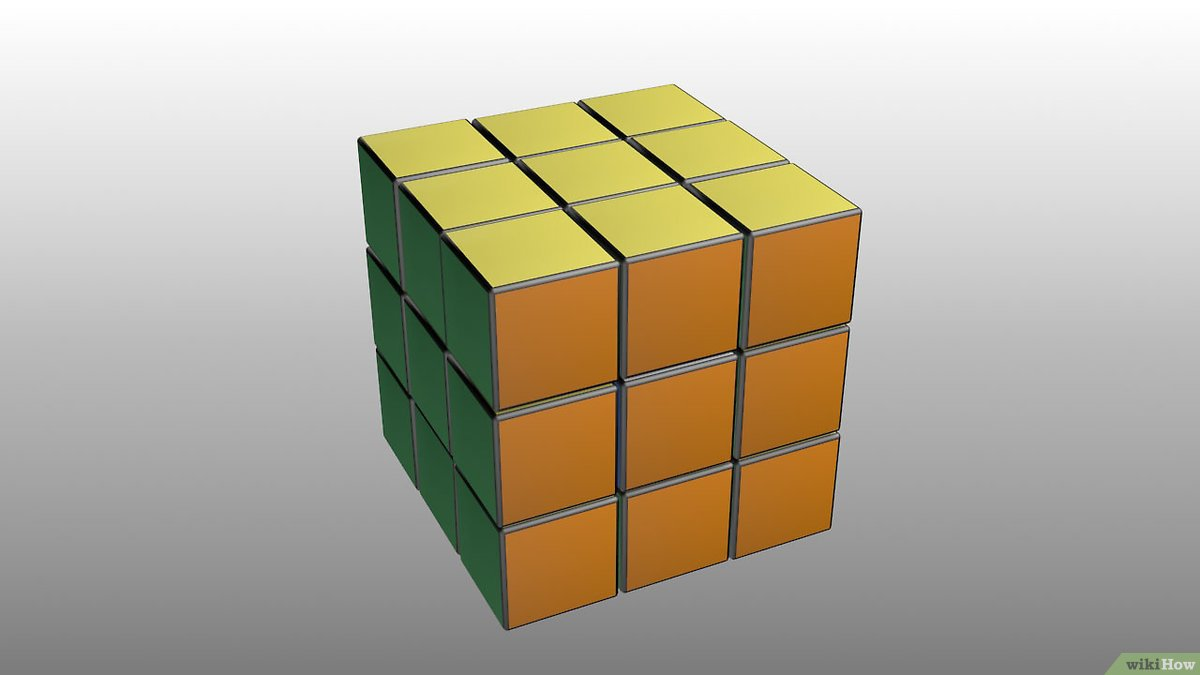

In [17]:
Image('corner/rubik.jpg')

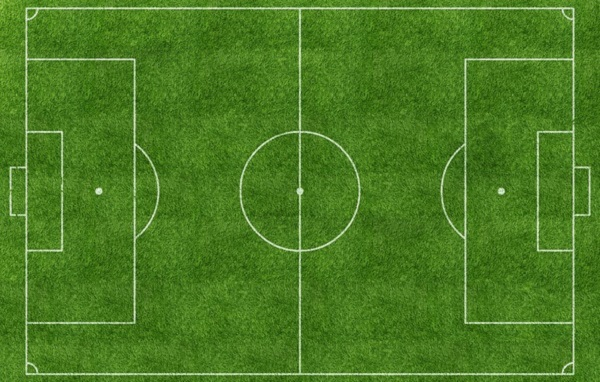

In [18]:
Image('corner/stadium.jpg')

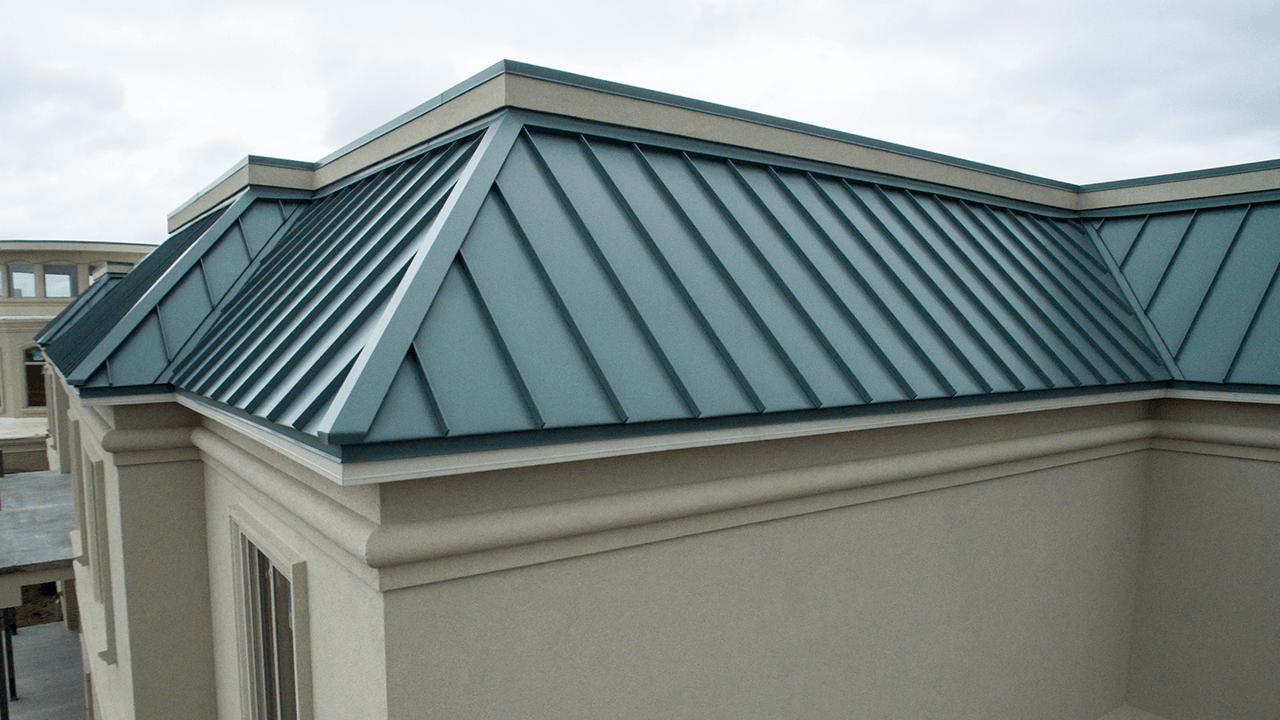

In [19]:
Image('corner/roof.png')

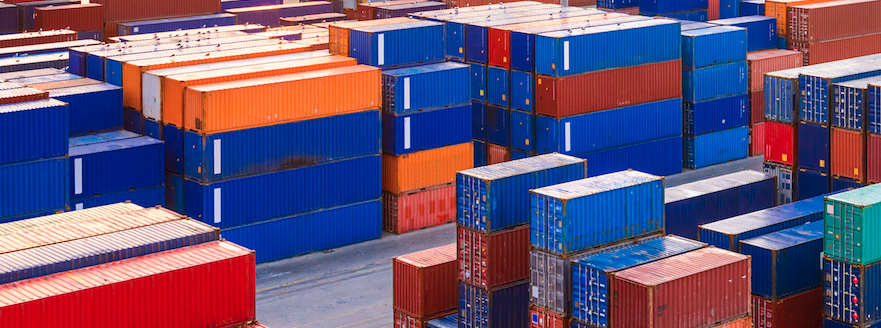

In [20]:
Image('corner/port.png')

Keypoint matching

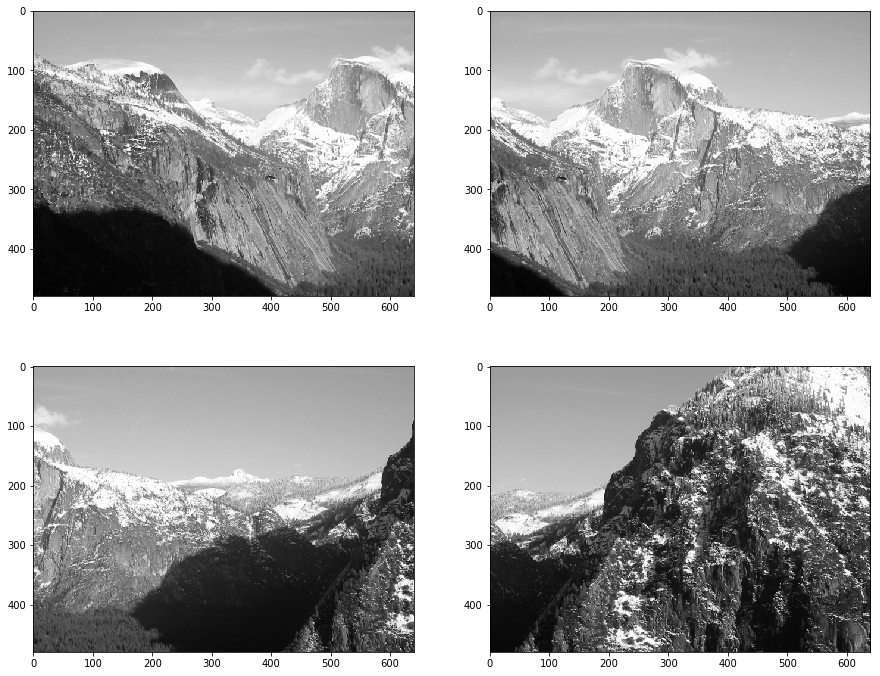

In [21]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplot(221)
plt.imshow(cv2.imread('yosemite1.jpg', 0), cmap='gray')

plt.subplot(222)
plt.imshow(cv2.imread('yosemite2.jpg', 0), cmap='gray')

plt.subplot(223)
plt.imshow(cv2.imread('yosemite3.jpg', 0), cmap='gray')

plt.subplot(224)
plt.imshow(cv2.imread('yosemite4.jpg', 0), cmap='gray')
